# Monitoring road condition with smartphone accelerometer and gps.

I have a bluetooth OBD2 adapter connected to my car (a 2002 Citroen C3) from which I can extract driving data (using my Android and Torque app). This has allowed me to do several analysis on how to drive my car more efficientely (e.g. for better mileage). It logs data from lots of different sensors and I've been thinking about some useful to use most of them. One of these sensors is the smartphones accelerometer. While I drive I put my smartphone in a windshield holder which is sufficientely flexible to allow my smartphone to oscillate - and although it is always oscillating, I noticed it usually shakes pretty badly when road conditions are equally bad. 

Since the Torque application also logs GPS position, I can spacially map where the biggest oscillations happen, thus perhaps I could gather more information on the road state, whether it is in a generally bad conditions or if it has pot holes. This information is useful since several government programs now allow citizens to report such problems. With this approach one would just need to drive around ( given some specific conditions, such as a fixed smartphone position) to gather large arrays of data on road quality. Some data analytics and prediction would make this probably an effective, low cost method.

The log I'll use was recorded in a 8km/10min drive around my home, where I'd say the road condition was overall ok but I went through some pretty rough spots. Lets see check if I can detect them solely with my smartphone sensors.

I didn't know back then, but there was already some [research](http://www.sciencedirect.com/science/article/pii/S1877042814000585) on this.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context('talk')
%matplotlib inline

In [2]:
df = pd.read_csv("file:///home/hypathia/Desktop/trackLog-2017-Feb-15_15-32-50.csv")

In [3]:
# For some reason the df numerical values are imported as strings, I guess it's because
# when Torque logs some values as '-' when the sensors aren't ready.
df = df.convert_objects(convert_numeric=True)

# Showcase the dataframe variables and type of values.
df.dropna().head()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


,GPS Time,Device Time,Longitude,Latitude,GPS Speed (Meters/second),Horizontal Dilution of Precision,Altitude,Bearing,G(x),G(y),G(z),G(calibrated),Speed (OBD)(km/h),Throttle Position(Manifold)(%),Engine RPM(rpm),Intake Air Temperature(°C),Litres Per 100 Kilometer(Instant)(l/100km),Intake Manifold Pressure(psi),Fuel flow rate/minute(gal/min)
28,Wed Feb 15 15:34:25 WET 2017,15-Feb-2017 15:34:25.997,-9.352397,38.804373,0.0,5.4,187.2,0.0,-9.74,0.22,0.31,-0.01,1,14.90,1061,17,176.31,5.51,0.01
29,Wed Feb 15 15:34:26 WET 2017,15-Feb-2017 15:34:26.693,-9.352400,38.804387,0.0,5.3,187.3,0.0,-9.96,0.34,0.37,0.04,3,14.90,1044,17,180.10,5.66,0.01
30,Wed Feb 15 15:34:27 WET 2017,15-Feb-2017 15:34:27.326,-9.352402,38.804402,0.0,5.1,188.1,0.0,-9.61,0.07,0.02,-0.00,2,14.51,1061,17,59.07,5.66,0.01
31,Wed Feb 15 15:34:27 WET 2017,15-Feb-2017 15:34:27.949,-9.352402,38.804402,0.0,5.1,188.1,0.0,-9.55,0.38,-0.11,-0.01,2,14.90,1056,17,87.74,5.51,0.01
32,Wed Feb 15 15:34:28 WET 2017,15-Feb-2017 15:34:28.640,-9.352402,38.804408,0.0,5.0,186.5,0.0,-9.61,0.91,-0.41,0.00,3,14.51,1055,17,89.62,5.66,0.01


There are 4 variables logged from the accelerometer. I'll use the callibrated variable calculated from the x, z and y axis, G(calibrated).

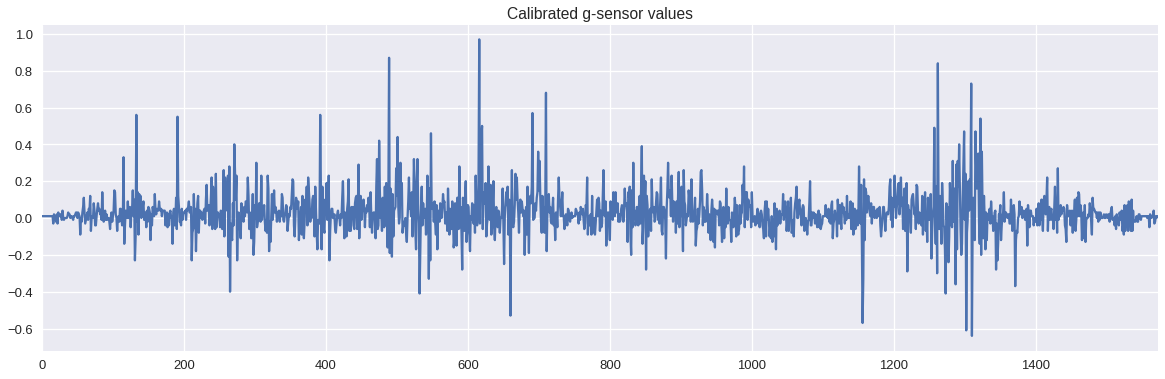

In [4]:
gcal = df[' G(calibrated)']

gcal.plot(kind="line",
          figsize=(20,6),
          title = 'Calibrated g-sensor values')

One possible approach to identify local maxima and minima points is through deviation from the mean. Three times the std seems strict enough.

(-1, 1)

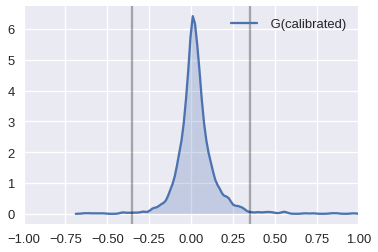

In [5]:
std = np.std(gcal)

sns.kdeplot(gcal, shade=True)
plt.axvline(x=3*std, alpha=.3, color='black', label = "3*Std")
plt.axvline(x=-3*std, alpha=.3, color='black')
plt.xlim([-1,1])

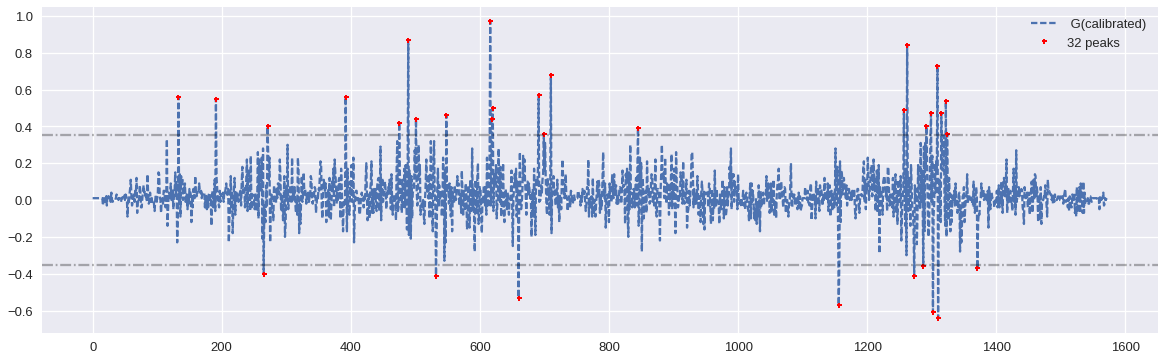

In [6]:
from peakutils.plot import plot as pplot

x = np.arange(0, len(gcal), 1)
y = gcal
std = np.std(gcal)

idx = np.logical_or(gcal > 3*std, gcal < -3*std)
idx  = np.where(idx)[0]

plt.figure(figsize=(20,6))
pplot(x, y, idx)
plt.axhline(y=3*std, alpha=0.3, color='black', linestyle='-.')
plt.axhline(y=-3*std, alpha=0.3, color='black', linestyle='-.')


In [7]:
df['Peaks'] = np.zeros(len(df))
    
for i in idx:
     df = df.set_value(index=idx, col='Peaks', value=1)

print(df.Peaks.value_counts())

0.0    1541
1.0      32
Name: Peaks, dtype: int64


In [ ]:
# Subset only indexes where peak is 1
peakCoords = df[df.Peaks==1][[' Longitude', ' Latitude']]

I realize the peak calling method I used isn't optimal: it's too ambiguous so I had to be really strict (3 times the std). Ideally I would drive in different known conditions (such as bad roads, good roads, potholes, etc) and feed each accelerometer signal to a neural network, so I could predict signatures instead of peaks. Also, Hidden Markov Models could work aswell.

For now lets if this simple approach returns any relevant road condition info. Each peak has GPS coordinates, so we can map it with Folium, a python Leaflet wrapper.

In [8]:
import folium

mapa = folium.Map([38.8055650, -9.341],
                  zoom_start=17)

for idx, row in peakCoords.iterrows():
    folium.Marker([row[1], row[0]], icon = folium.Icon(color ='red')).add_to(mapa)
    
mapa

Rua Reinaldo dos Santos is surely in bad condition: driving there felt pretty rough, which was also captured by the accelerometer, so I the concept works. Perhaps there is a specific signature to each event (good, ok and bad road condition, aswell as potholes and such things) that could be fed to a neural network, which would allow predicting road conditions through specific signatures instead of high peak values. This would require to drive in controlled conditions (known road state) to capture single signatures. I'm willing to do it someday.

For now, you can check the road quality on both points I specified. 

In [9]:
from IPython import display

display.IFrame('https://www.google.com/maps/embed?pb=!1m0!3m2!1sen!2sus!4v1487801082835!6m8!1m7!1sm6K24rBCKjk_TGrVlBqa6w!2m2!1d38.80615127073316!2d-9.343520464111833!3f249.41317672431592!4f-42.1403933451385!5f0.7820865974627469', width="600", height="450")

Yep, the road 'Reinaldo dos Santos' is in need of some repairs. 

Also, the single event recorded in Estrada do Algueirao is shown below.

In [10]:
display.IFrame("https://www.google.com/maps/embed?pb=!1m0!3m2!1sen!2sus!4v1487801880794!6m8!1m7!1sTjyO2XlzCTbx5QbJQEomQw!2m2!1d38.80453411871716!2d-9.339393785462363!3f52.85862362860266!4f-29.61261759630741!5f0.7820865974627469", width="600", height="450") 

Also in pretty bad shape. 

In [11]:
## This chunk is only relevant for Jupyter Notebook aesthetics.
from pylab import rcParams
import json
s = json.load( open("/home/hypathia/bmh_matplotlibrc.json") ) 
rcParams.update(s)

from IPython.core.display import HTML
def css_styling():
    styles = open("/home/hypathia/custom.css", "r").read() 
    return HTML(styles)
css_styling()